In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
df = pd.read_csv('email.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Category,Message
count,5573,5573
unique,3,5158
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df['Category'].value_counts()

Category
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64

In [20]:
df = df[df['Category'].isin(['ham', 'spam'])]
print(df['Category'].value_counts())

Category
ham     4825
spam     747
Name: count, dtype: int64


# EDA

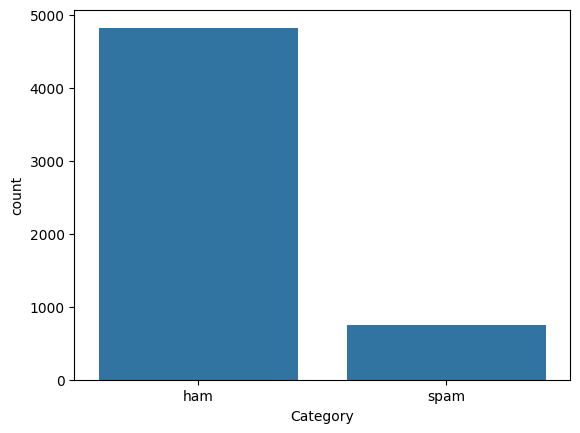

In [21]:
sns.countplot(data=df, x='Category')
plt.show()

/tmp/ipykernel_75457/2742755226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message_length'] = df['Message'].apply(len)


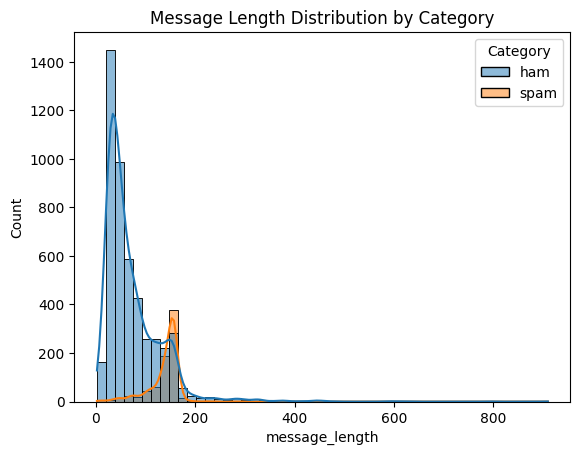

In [22]:
df['message_length'] = df['Message'].apply(len)

# Plotting distribution of message lengths
sns.histplot(data=df, x='message_length', hue='Category', bins=50, kde=True)
plt.title("Message Length Distribution by Category")
plt.show()

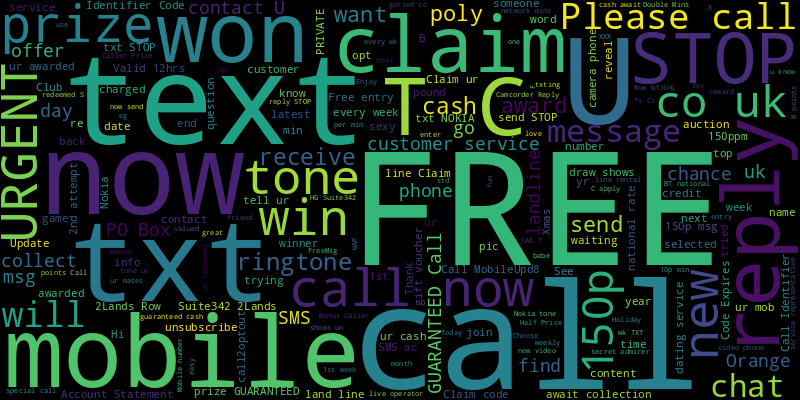

In [23]:
from wordcloud import WordCloud

spam_words = ' '.join(df[df['Category'] == 'spam']['Message'])
ham_words = ' '.join(df[df['Category'] == 'ham']['Message'])

# Spam WordCloud
WordCloud(width=800, height=400).generate(spam_words).to_image()

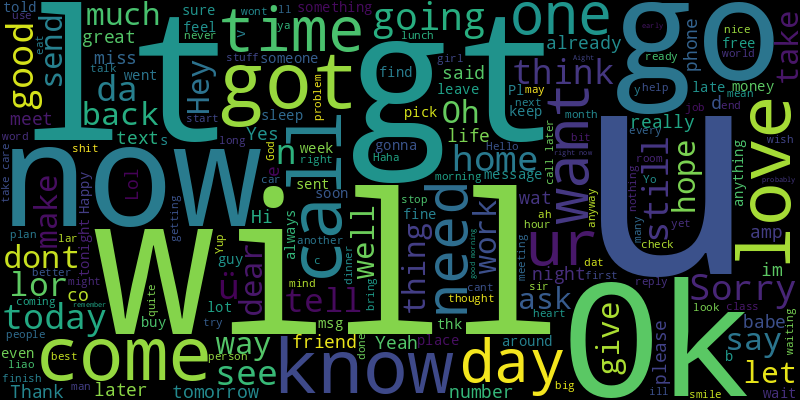

In [24]:
# Ham WordCloud
WordCloud(width=800, height=400).generate(ham_words).to_image()


# Feature Engineering

In [16]:
import re
from sklearn.model_selection import train_test_split

In [25]:
# Clean text
def clean_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return text

df['clean_message'] = df['Message'].apply(clean_text)

# Label Encoding
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

/tmp/ipykernel_75457/326392254.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_message'] = df['Message'].apply(clean_text)
/tmp/ipykernel_75457/326392254.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Category'].map({'ham': 0, 'spam': 1})


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [33]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_vec, y_train)

# Predict
y_pred = clf.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.979372197309417
F1 Score:  0.9163636363636364
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[966   0]
 [ 23 126]]


In [40]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_vec, y_train)
y_pred_xgb = xgb_model.predict(X_test_vec)

print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:57:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.9721973094170404
F1 Score:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.95      0.83      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

[[960   6]
 [ 25 124]]


# Tuning

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [36]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Grid search
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_vec, y_train)

# Best model
print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF Score:", rf_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best RF Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF Score: 0.9833967477465235


In [39]:
y_pred_rf = rf_grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9820627802690582
F1 Score:  0.9280575539568345
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[966   0]
 [ 20 129]]


In [42]:
# Parameter grid
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Randomized search
xgb_random = RandomizedSearchCV(xgb, xgb_params, n_iter=50, cv=5,
                                verbose=1, random_state=42, n_jobs=-1, scoring='accuracy')
xgb_random.fit(X_train_vec, y_train)

# Best model
print("Best XGB Parameters:", xgb_random.best_params_)
print("Best XGB Score:", xgb_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:58:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:58:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:58:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:58:04] WARNING: /workspace/src/learner.cc:738: 
Paramet

Best XGB Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best XGB Score: 0.9750970089535113


In [ ]:
# Evaluate
y_pred_xgb = xgb_random.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Accuracy:  0.9695067264573991
F1 Score:  0.8776978417266187
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.95      0.82      0.88       149

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[959   7]
 [ 27 122]]


Exception ignored in: <function ResourceTracker.__del__ at 0x7f3c4ac41300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f1c0ce49300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f236f555300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip